In [50]:
import sympy as sp
import math
import scipy.optimize as opt
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sympy.solvers.solveset import linsolve, Matrix

In [2]:
#（1） 编写线搜索程序, 并且在检验函数上测试
def PowellBadlyScaled(x='x1 x2'):
    x = sp.symbols(x)
    r1 = (10**4) * x[0] * x[1] -1
    r2 = sp.exp(-x[0]) + sp.exp(-x[1]) - 1.0001
    r = [r1,r2]
    f = sum([i**2 for i in r])
    x0 = [0,1]
    return f,r,x,x0

def DiscreteBoundaryValue(n=10):
    h = 1/(n+1)
    x = sp.symbols(" ".join(['x%d'%(i+1) for i in range(n)]))
    x0 = [i*h*(i*h-1) for i in range(1,n+1)]
    X = [0,*x,0]
    r = [ 2 * X[i] - X[i-1] - X[i+1] + (h**2)*((X[i]+i*h +1)**3)/2 
         for i in range(1,n+1)]
    f = sum([i**2 for i in r])
    return f,r,x,x0

def ExtendedPowellSingular(n=12):
    x = sp.symbols(" ".join(['x%d'%(i+1) for i in range(n)]))
    r = []
    for i in range(n):
        if i%4 == 0:
            r.append(x[i]+10*x[i+1])
        elif i%4 == 1:
            r.append((5**0.5)*(x[i+1]-x[i+2]))
        elif i%4 == 2:
            r.append((x[i-1]-2*x[i])**2)
        else:
            r.append((10**0.5)*(x[i-3]-x[i]))
    f = sum([i**2 for i in r])     
    return f,r,x

In [12]:
#寻找单峰区间 "高-低-高"
def SolveRange(f,x,x_init,grad,t=1.1,step=1e-7):
    n = len(x)
    x_values = {x[i]:x_init[i] for i in range(n)}
    x_updated = {x[i]:x_init[i] + grad[i] * step for i in range(n)}
    grad = {x[i]:grad[i] for i in range(n)}
    bound1 = f.evalf(subs= x_values)
    x_bound1 = x_values
    if f.evalf(subs=x_values) < f.evalf(subs=x_updated):
        x_bound1, bould1 = x_updated, f.evalf(subs=x_updated)
        x_values = x_bound1
        step = - step
        x_updated = {x_i:x_values[x_i] + grad[x_i] * step for x_i in x}
        
    while f.evalf(subs={x_i:x_updated[x_i] + grad[x_i] * step for x_i in x}) < f.evalf(subs=x_updated):
        step *= t
        x_bound1 = x_updated
        x_updated = {x_i:x_updated[x_i] + grad[x_i] * step for x_i in x}
    x_bound2 = {x_i:x_updated[x_i] + grad[x_i] * step for x_i in x}
    return x_bound1,x_bound2

#解精确线搜索步长, 0.618方法
def SolveStepLength(f,x,x_bound1,x_bound2,epsilon = 10e-7):
    n = len(x)
    k = 0.61803
    inter1 = {x_i:k*x_bound1[x_i] + (1-k)*x_bound2[x_i] for x_i in x}
    inter2 = {x_i:(1-k)*x_bound1[x_i] + k*x_bound2[x_i] for x_i in x}
    if f.evalf(subs=inter1) < f.evalf(subs=inter2):
        x_bound1, x_bound2 = x_bound1, inter2
    else:
        x_bound1, x_bound2 = inter1, x_bound2
    normal2 = sum([(x_bound1[x_i]-x_bound2[x_i])**2 for x_i in x])
    if normal2 < epsilon:
        #print(f.evalf(subs=inter1),' -- ',normal2,x_bound1,x_bound2)
        return {x_i:(x_bound1[x_i] + x_bound2[x_i])/2 for x_i in x}
    else:
        #print(f.evalf(subs=inter1),' -- ',normal2,x_bound1,x_bound2)
        return SolveStepLength(f,x,x_bound1,x_bound2)

#迭代精确线搜素
def LineSearch(f,x,x0,end_eplison=1e-8):
    printedTimes = [1,5,10,20,50,100,200,300,500,1000,2000,3000,10000]
    countTime = 0
    n = len(x)
    x_current = {x[i]:x0[i] for i in range(n)}
    grad = [f.diff(x_i).evalf(subs=x_current) for x_i in x]
    normalGrad = sum([g**2 for g in grad])
    while normalGrad > end_eplison:
        countTime += 1
        x_bound1, x_bound2 = SolveRange(f,x,list(x_current.values()),grad,t=1.1,step=0.01)
        x_current = SolveStepLength(f,x,x_bound1,x_bound2)
        grad = [f.diff(x_i).evalf(subs=x_current) for x_i in x]
        normalGrad = sum([g**2 for g in grad])
        if countTime in printedTimes or (normalGrad < end_eplison):
            print('函数值: %.8f, '%f.evalf(subs=x_current),'迭代次数: 【%d】, '%countTime,'||g||:', normalGrad)
            for i in range(n):
                if (i+1)%5: endSymbol = ''
                else: endSymbol = '\n' 
                print(x[i],":%f"%x_current[x[i]],'  ',sep='',end=endSymbol)
            print()
        

In [82]:
f,r,x,x0 = DiscreteBoundaryValue()
LineSearch(f,x,x0,end_eplison=1e-8)
#达到设定的精度要求, 需要2871次迭代, 可见速度较慢。

函数值: 0.00071468,  迭代次数: 【1】,  ||g||: 0.00103246095601375
x1:-0.080170  x2:-0.148681  x3:-0.198256  x4:-0.231297  x5:-0.247803  
x6:-0.247775  x7:-0.231211  x8:-0.198115  x9:-0.148489  x10:-0.085544  

函数值: 0.00063729,  迭代次数: 【5】,  ||g||: 0.000313253239087241
x1:-0.078616  x2:-0.146127  x3:-0.197328  x4:-0.231361  x5:-0.247455  
x6:-0.247308  x7:-0.230255  x8:-0.198346  x9:-0.150819  x10:-0.086898  

函数值: 0.00059353,  迭代次数: 【10】,  ||g||: 0.000212674674715767
x1:-0.077245  x2:-0.143992  x3:-0.196005  x4:-0.230248  x5:-0.247168  
x6:-0.246485  x7:-0.230427  x8:-0.198856  x9:-0.152486  x10:-0.087989  

函数值: 0.00053227,  迭代次数: 【20】,  ||g||: 0.000183346404566279
x1:-0.075328  x2:-0.140943  x3:-0.192868  x4:-0.227732  x5:-0.245574  
x6:-0.245922  x7:-0.230983  x8:-0.200404  x9:-0.154402  x10:-0.089319  

函数值: 0.00041797,  迭代次数: 【50】,  ||g||: 0.000101092513208582
x1:-0.071392  x2:-0.134184  x3:-0.185006  x4:-0.220779  x5:-0.240913  
x6:-0.244378  x7:-0.232195  x8:-0.203441  x9:-0.157652  x10:-

In [8]:
f,r,x,x0 = PowellBadlyScaled()
LineSearch(f,x,x0,end_eplison=1e-8)
#对于这一检验函数, 普通的精确线搜索根本无法收敛。

函数值: 1.81834447,  迭代次数: 【1】,  ||g||: 673262566.325091
x1:0.000230  x2:1.000000  
函数值: 2.62429226,  迭代次数: 【5】,  ||g||: 995641533.254670
x1:-0.000058  x2:1.000000  
函数值: 2.47529753,  迭代次数: 【10】,  ||g||: 936043723.068650
x1:0.000253  x2:1.000000  
函数值: 0.16956306,  迭代次数: 【20】,  ||g||: 13749941.0315782
x1:0.000081  x2:1.000000  
函数值: 0.62351179,  迭代次数: 【50】,  ||g||: 195329311.718425
x1:0.000170  x2:1.000000  
函数值: 2.71120473,  迭代次数: 【100】,  ||g||: 1030405318.44395
x1:-0.000060  x2:0.999999  
函数值: 0.46719695,  迭代次数: 【200】,  ||g||: 132803094.698757
x1:0.000158  x2:0.999999  
函数值: 0.38586194,  迭代次数: 【300】,  ||g||: 100268990.793070
x1:0.000150  x2:0.999998  
函数值: 5.25660305,  迭代次数: 【500】,  ||g||: 2048554637.83951
x1:0.000326  x2:0.999997  


In [10]:
#求解Newton方向
def SolveNewtonDirection(f,x,x_init,v=0):
    n = len(x)
    x_values = x_init #{x[i]:x_init[i] for i in range(n)}
    g = [f.diff(x_i).evalf(subs=x_values) for x_i in x]
    G = [[f.diff(x_i).diff(x_j).evalf(subs=x_values) for x_j in x] for x_i in x]
    system = Matrix(G) + sp.diag(*[1 for i in range(n)]) * v,Matrix(g)
    return linsolve(system,*x)

#阻尼Newton方法。以及修正Newton方法, 这里我选用 LM 方法, 作为关键词参数传入
def DampedNewton(f,x,x0,end_eplison=1e-8, LM=False,v_value=1e-1):
    v = [0,v_value][LM]
    printedTimes = [1,2,3,4,5,10,20,50,100,200,300,500,1000,2000,3000,10000]
    countTime = 0
    n = len(x)
    x_current = {x[i]:x0[i] for i in range(n)}
    grad = list(SolveNewtonDirection(f,x,x_current,v))[0]
    normalGrad = sum([g**2 for g in grad])
    while normalGrad > end_eplison:
        countTime += 1
        x_bound1, x_bound2 = SolveRange(f,x,list(x_current.values()),grad,t=1.1,step=0.01)
        x_current = SolveStepLength(f,x,x_bound1,x_bound2)
        grad = list(SolveNewtonDirection(f,x,x_current,v))[0]
        normalGrad = sum([g**2 for g in grad])
        if countTime in printedTimes or (normalGrad < end_eplison):
            print('函数值: %.8f, '%f.evalf(subs=x_current),'迭代次数: 【%d】, '%countTime,'||g||:', normalGrad)
            for i in range(n):
                if (i+1)%5: endSymbol = ''
                else: endSymbol = '\n' 
                print(x[i],":%.8f"%x_current[x[i]],'  ',sep='',end=endSymbol)
            print()

In [11]:
#调用各个检验函数都大同小异 以DBV为例
f,r,x,x0 = DiscreteBoundaryValue()
DampedNewton(f,x,x0,end_eplison=1e-9)
#二次终止性

函数值: 0.00000018,  迭代次数: 【1】,  ||g||: 8.27383242378997e-6
x1:-0.04304665  x2:-0.08118304  x3:-0.11376620  x4:-0.13996955  x5:-0.15871889  
x6:-0.16862185  x7:-0.16788146  x8:-0.15417969  x9:-0.12450686  x10:-0.07489670  

函数值: 0.00000000,  迭代次数: 【2】,  ||g||: 9.20910903457644e-10
x1:-0.04316612  x2:-0.08158119  x3:-0.11449321  x4:-0.14098412  x5:-0.15992122  
x6:-0.16989044  x7:-0.16910275  x8:-0.15526086  x9:-0.12536492  x10:-0.07542210  



In [189]:
f,r,x,x0 = DiscreteBoundaryValue()
DampedNewton(f,x,x0,end_eplison=1e-9,LM=True,v_value=1e-2)
# LM修正可以解决G不是正定时候的情况, 在v很小时偏向于Newton方向, 较大时偏向于负梯度方向.

函数值: 0.00002257,  迭代次数: 【1】,  ||g||: 0.000671834208447572
x1:-0.045659  x2:-0.087649  x3:-0.124288  x4:-0.153949  x5:-0.175040  
x6:-0.185908  x7:-0.184699  x8:-0.169137  x9:-0.136224  x10:-0.081812  

函数值: 0.00000069,  迭代次数: 【2】,  ||g||: 1.73966598511374e-5
x1:-0.044301  x2:-0.083472  x3:-0.116844  x4:-0.143551  x5:-0.162486  
x6:-0.172246  x7:-0.171058  x8:-0.156663  x9:-0.126145  x10:-0.075657  

函数值: 0.00000002,  迭代次数: 【3】,  ||g||: 7.25954768109115e-7
x1:-0.043270  x2:-0.081817  x3:-0.114853  x4:-0.141438  x5:-0.160426  
x6:-0.170403  x7:-0.169584  x8:-0.155677  x9:-0.125685  x10:-0.075611  

函数值: 0.00000000,  迭代次数: 【4】,  ||g||: 1.16911135260381e-8
x1:-0.043196  x2:-0.081627  x3:-0.114545  x4:-0.141038  x5:-0.159975  
x6:-0.169939  x7:-0.169143  x8:-0.155288  x9:-0.125376  x10:-0.075420  

函数值: 0.00000000,  迭代次数: 【5】,  ||g||: 5.89734493572631e-10
x1:-0.043168  x2:-0.081584  x3:-0.114497  x4:-0.140987  x5:-0.159924  
x6:-0.169892  x7:-0.169104  x8:-0.155261  x9:-0.125365  x10:-0.075

In [14]:
#对于普通线搜索无法收敛的Powell Badly Scaled检验函数, 阻尼牛顿也可以收敛到极值点。
f,r,x,x0 = PowellBadlyScaled()
DampedNewton(f,x,x0,end_eplison=1e-11,LM=False)

函数值: 0.01110008,  迭代次数: 【1】,  ||g||: 0.352372877967997
x1:0.00004478  x2:2.25237981  
函数值: 0.00594748,  迭代次数: 【2】,  ||g||: 0.0891935334937511
x1:0.00003684  x2:2.63612119  
函数值: 0.00098584,  迭代次数: 【3】,  ||g||: 0.0610914448377747
x1:0.00002794  x2:3.53600112  
函数值: 0.00025436,  迭代次数: 【4】,  ||g||: 0.0400902599818121
x1:0.00002359  x2:4.21262473  
函数值: 0.00007927,  迭代次数: 【5】,  ||g||: 0.0293871202061604
x1:0.00002087  x2:4.77634498  
函数值: 0.00000269,  迭代次数: 【10】,  ||g||: 0.00786660104042555
x1:0.00001564  x2:6.39032718  
函数值: 0.00000008,  迭代次数: 【20】,  ||g||: 0.00186118667789771
x1:0.00001273  x2:7.85343455  
函数值: 0.00000000,  迭代次数: 【48】,  ||g||: 3.06326006771370e-15
x1:0.00001098  x2:9.10614668  


In [44]:
#(3) 编写拟牛顿方法
# 这一部分的Heiss矩阵更新过程比较复杂, 故不采用纯自己手动编写的方式, 直接调用python scipy中的函数比如scipy.optimize即可, 具体例子如下
#res = minimize(f, x0, method='BFGS', jac=x,
#               options={'disp': True})


#也可以直接如下调用
"""
from scipy.optimize import BFGS
from scipy.optimize import NonlinearConstraint
nonlinear_constraint = NonlinearConstraint(cons_f, -np.inf, 1, jac=cons_J, hess=BFGS())
"""

#同理对于 SR1, 对称秩1方法. 也是同样调用.
from scipy.optimize import SR1
res = minimize(f, x0, method='trust-constr',  jac="2-point", hess=SR1(),
                constraints=[linear_constraint, nonlinear_constraint],
                options={'verbose': 1}, bounds=bounds)

Optimization terminated successfully.
Current function value: 0.000000
Iterations: 51                     
Function evaluations: 63
Gradient evaluations: 63
         

`gtol` termination condition is satisfied.
Number of iterations: 12, function evaluations: 24, CG iterations: 7, optimality: 4.48e-09, constraint violation: 0.00e+00, execution time: 0.016 s.



### 关于各个方向之间的对比, 迭代用时较久, 故仅对一些进行讨论.

#### Powell Badly Scaled 作为检验函数

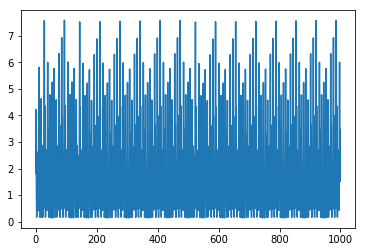

In [53]:
#线搜索函数值的变化,可以看出明显不收敛
plt.plot(f_value)

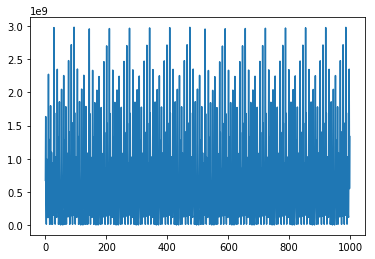

In [54]:
#线搜索函梯度的变化,也可以看出明显不收敛
plt.plot(grad)

#### 阻尼牛顿的表现

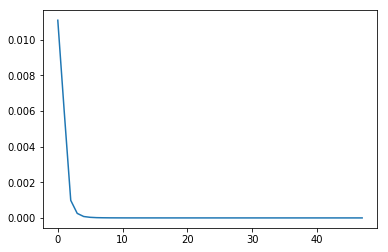

In [56]:
#函数值,可以看到飞快的收敛
plt.plot(f_value)

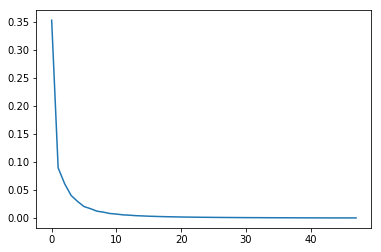

In [57]:
#梯度, 也可以看到飞快的收敛
plt.plot(grad)

#### Discrete Boundary Value作为检验函数

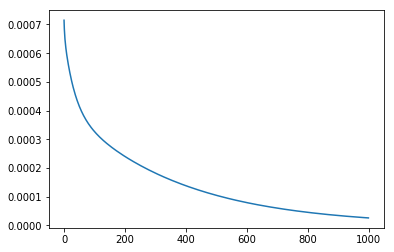

In [59]:
#线搜索函数值的变化, 迭代效率较低, 收敛速度慢
plt.plot(f_value)

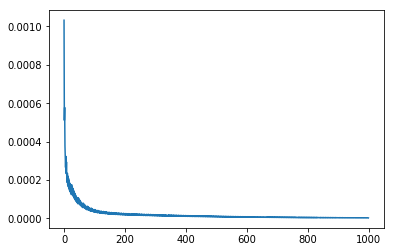

In [62]:
#线搜索梯度的变化, 还是较快收敛,
plt.plot(grad)

阻尼牛顿方法

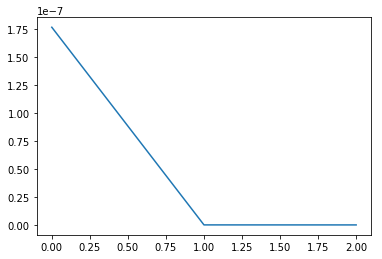

In [66]:
#阻尼牛顿迭代, 可以基本上看出有二次终止性
plt.plot(f_value)

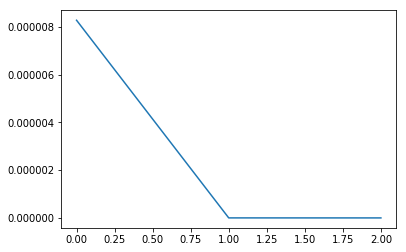

In [67]:
#梯度值
plt.plot(grad)